# RNN Transfer Demonstration with Steady States

The goal of this notebook is to analyze time-rescaling of a pre-trained RNN when predicting constant data. When the RNN is "well behaved" and approaches an equilibrium at some characteristic rate, scaling the bias terms of the forget and input gate can change the rate at which the system equilibrates

The RNN was pre-trained on 10h FMC sensors, with atmospheric inputs standard scaled.

## Setup

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from src.models import moisture_rnn as mrnn
from src.utils import read_yml, time_intp, plot_styles

In [2]:
# Read Trained model
params = read_yml("models/params.yaml")
rnn = mrnn.RNN_Flexible(params=params)
scaler = joblib.load("models/scaler.joblib")

/Users/hirschij/Documents/Projects/Wildfire/fmc_transfer/src/models/moisture_rnn.py:483: UserWarning: timesteps should be None for flexible RNNs. Overriding to None.
  warnings.warn(f"{param} should be None for flexible RNNs. Overriding to None.")
/opt/anaconda3/envs/fmc/lib/python3.11/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
rnn.load_weights('models/rnn.keras')

/opt/anaconda3/envs/fmc/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [4]:
# Extract Info from RNN
lstm = rnn.get_layer("lstm")
lstm_units = lstm.units
weights10 = lstm.get_weights()

In [5]:
ml_data = pd.read_pickle("models/ml_data.pkl")

## Construct Predictors

In [6]:
print(params["features_list"])

['Ed', 'Ew', 'solar', 'wind', 'elev', 'lon', 'lat', 'rain', 'hod', 'doy']


In [7]:
spinup = 3
psteps = 48
nsteps = spinup+psteps
# All zero inputs after transform, so mean of training set features
x0 = np.repeat(scaler.mean_[None, :], nsteps, axis=0)

In [8]:
# Station in Rocky Mountain Arsenal
st1 = "AENC2"
dat1 = ml_data[st1]["data"].iloc[-1] # Last available time
x1 = dat1[params["features_list"]].to_numpy(dtype=np.float32)
x1 = np.repeat(x1[None, :], nsteps, axis=0)
print(f"Station: {st1}")
print(f"Time (UTC): {ml_data[st1]['times'][-1]}")
print(dat1[params["features_list"]])

Station: AENC2
Time (UTC): 2024-12-31 23:00:00+00:00
Ed       15.685835
Ew       14.295031
solar    92.300003
wind       4.33158
elev     1602.3336
lon     -104.85572
lat       39.82425
rain           0.0
hod             23
doy            366
Name: 16031, dtype: object


In [9]:
# Station in Estes Park, near Rocky Mtn National Park
st2 = "ESPC2"
dat2 = ml_data[st2]["data"].iloc[12345] # arbitrary time slice, lands in August
x2 = dat2[params["features_list"]].to_numpy(dtype=np.float32)
x2 = np.repeat(x2[None, :], nsteps, axis=0)
print(f"Station: {st2}")
print(f"Time (UTC): {ml_data[st2]['times'][-1]}")
print(dat2[params["features_list"]])

Station: ESPC2
Time (UTC): 2024-12-31 23:00:00+00:00
Ed       19.152634
Ew       17.709454
solar          0.0
wind        2.7987
elev     2405.4816
lon     -105.56278
lat       40.36636
rain           0.0
hod              9
doy            229
Name: 12345, dtype: object


In [10]:
# Scale
X0 = scaler.transform(x0.copy())
X1 = scaler.transform(x1.copy())
X2 = scaler.transform(x2.copy())

# Reshape
X0 = X0[None, :, :]
X1 = X1[None, :, :]
X2 = X2[None, :, :]

## Generate RNN Predictions

Make grid of all zeros, corresponding to mean of all inputs. Then increase or decrease equilibria while holding others to zeros.

### 10h-Weight Predictions

Normal pre-trained weights. Extract weights for reuse

In [11]:
p0 = rnn.predict(X0).flatten()
p1 = rnn.predict(X1).flatten()
p2 = rnn.predict(X2).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [12]:
units = rnn.get_layer("lstm").units
weights0 = [w.copy() for w in rnn.get_layer("lstm").get_weights()]

### Speed up

In [13]:
weights_fast = rnn.get_layer("lstm").get_weights()
weights_fast[2][0:units]       = weights0[2][0:units] + 0.5
weights_fast[2][units:2*units] = weights0[2][units:2*units] - 0.5

### Slow Down

In [14]:
weights_slow = rnn.get_layer("lstm").get_weights()
weights_slow[2][0:units]       = weights0[2][0:units] - 0.5
weights_slow[2][units:2*units] = weights0[2][units:2*units] + 0.5

### Predictions with modified weights

In [15]:
rnn.get_layer("lstm").set_weights(weights_fast)
p0_fast = rnn.predict(X0).flatten()
p1_fast = rnn.predict(X1).flatten()
p2_fast = rnn.predict(X2).flatten()

rnn.get_layer("lstm").set_weights(weights_slow)
p0_slow = rnn.predict(X0).flatten()
p1_slow = rnn.predict(X1).flatten()
p2_slow = rnn.predict(X2).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


## Viz

In [16]:
import matplotlib.colors as mcolors
c0 = plot_styles["fm"]["color"]  # '#468a29'

# convert to RGB
rgb0 = np.array(mcolors.to_rgb(c0))

# define lighter and darker variants
light = rgb0 + 0.35 * (1.0 - rgb0)
dark  = rgb0 * 0.65

# clamp to [0, 1]
colors = [
    mcolors.to_hex(np.clip(light, 0, 1)),
    mcolors.to_hex(np.clip(rgb0,  0, 1)),
    mcolors.to_hex(np.clip(dark,  0, 1)),
]

In [17]:
import matplotlib
cmap = matplotlib.colormaps.get_cmap("viridis")
n = 3
colors = [mcolors.to_hex(cmap(i)) for i in np.linspace(0.2, 0.9, n)]

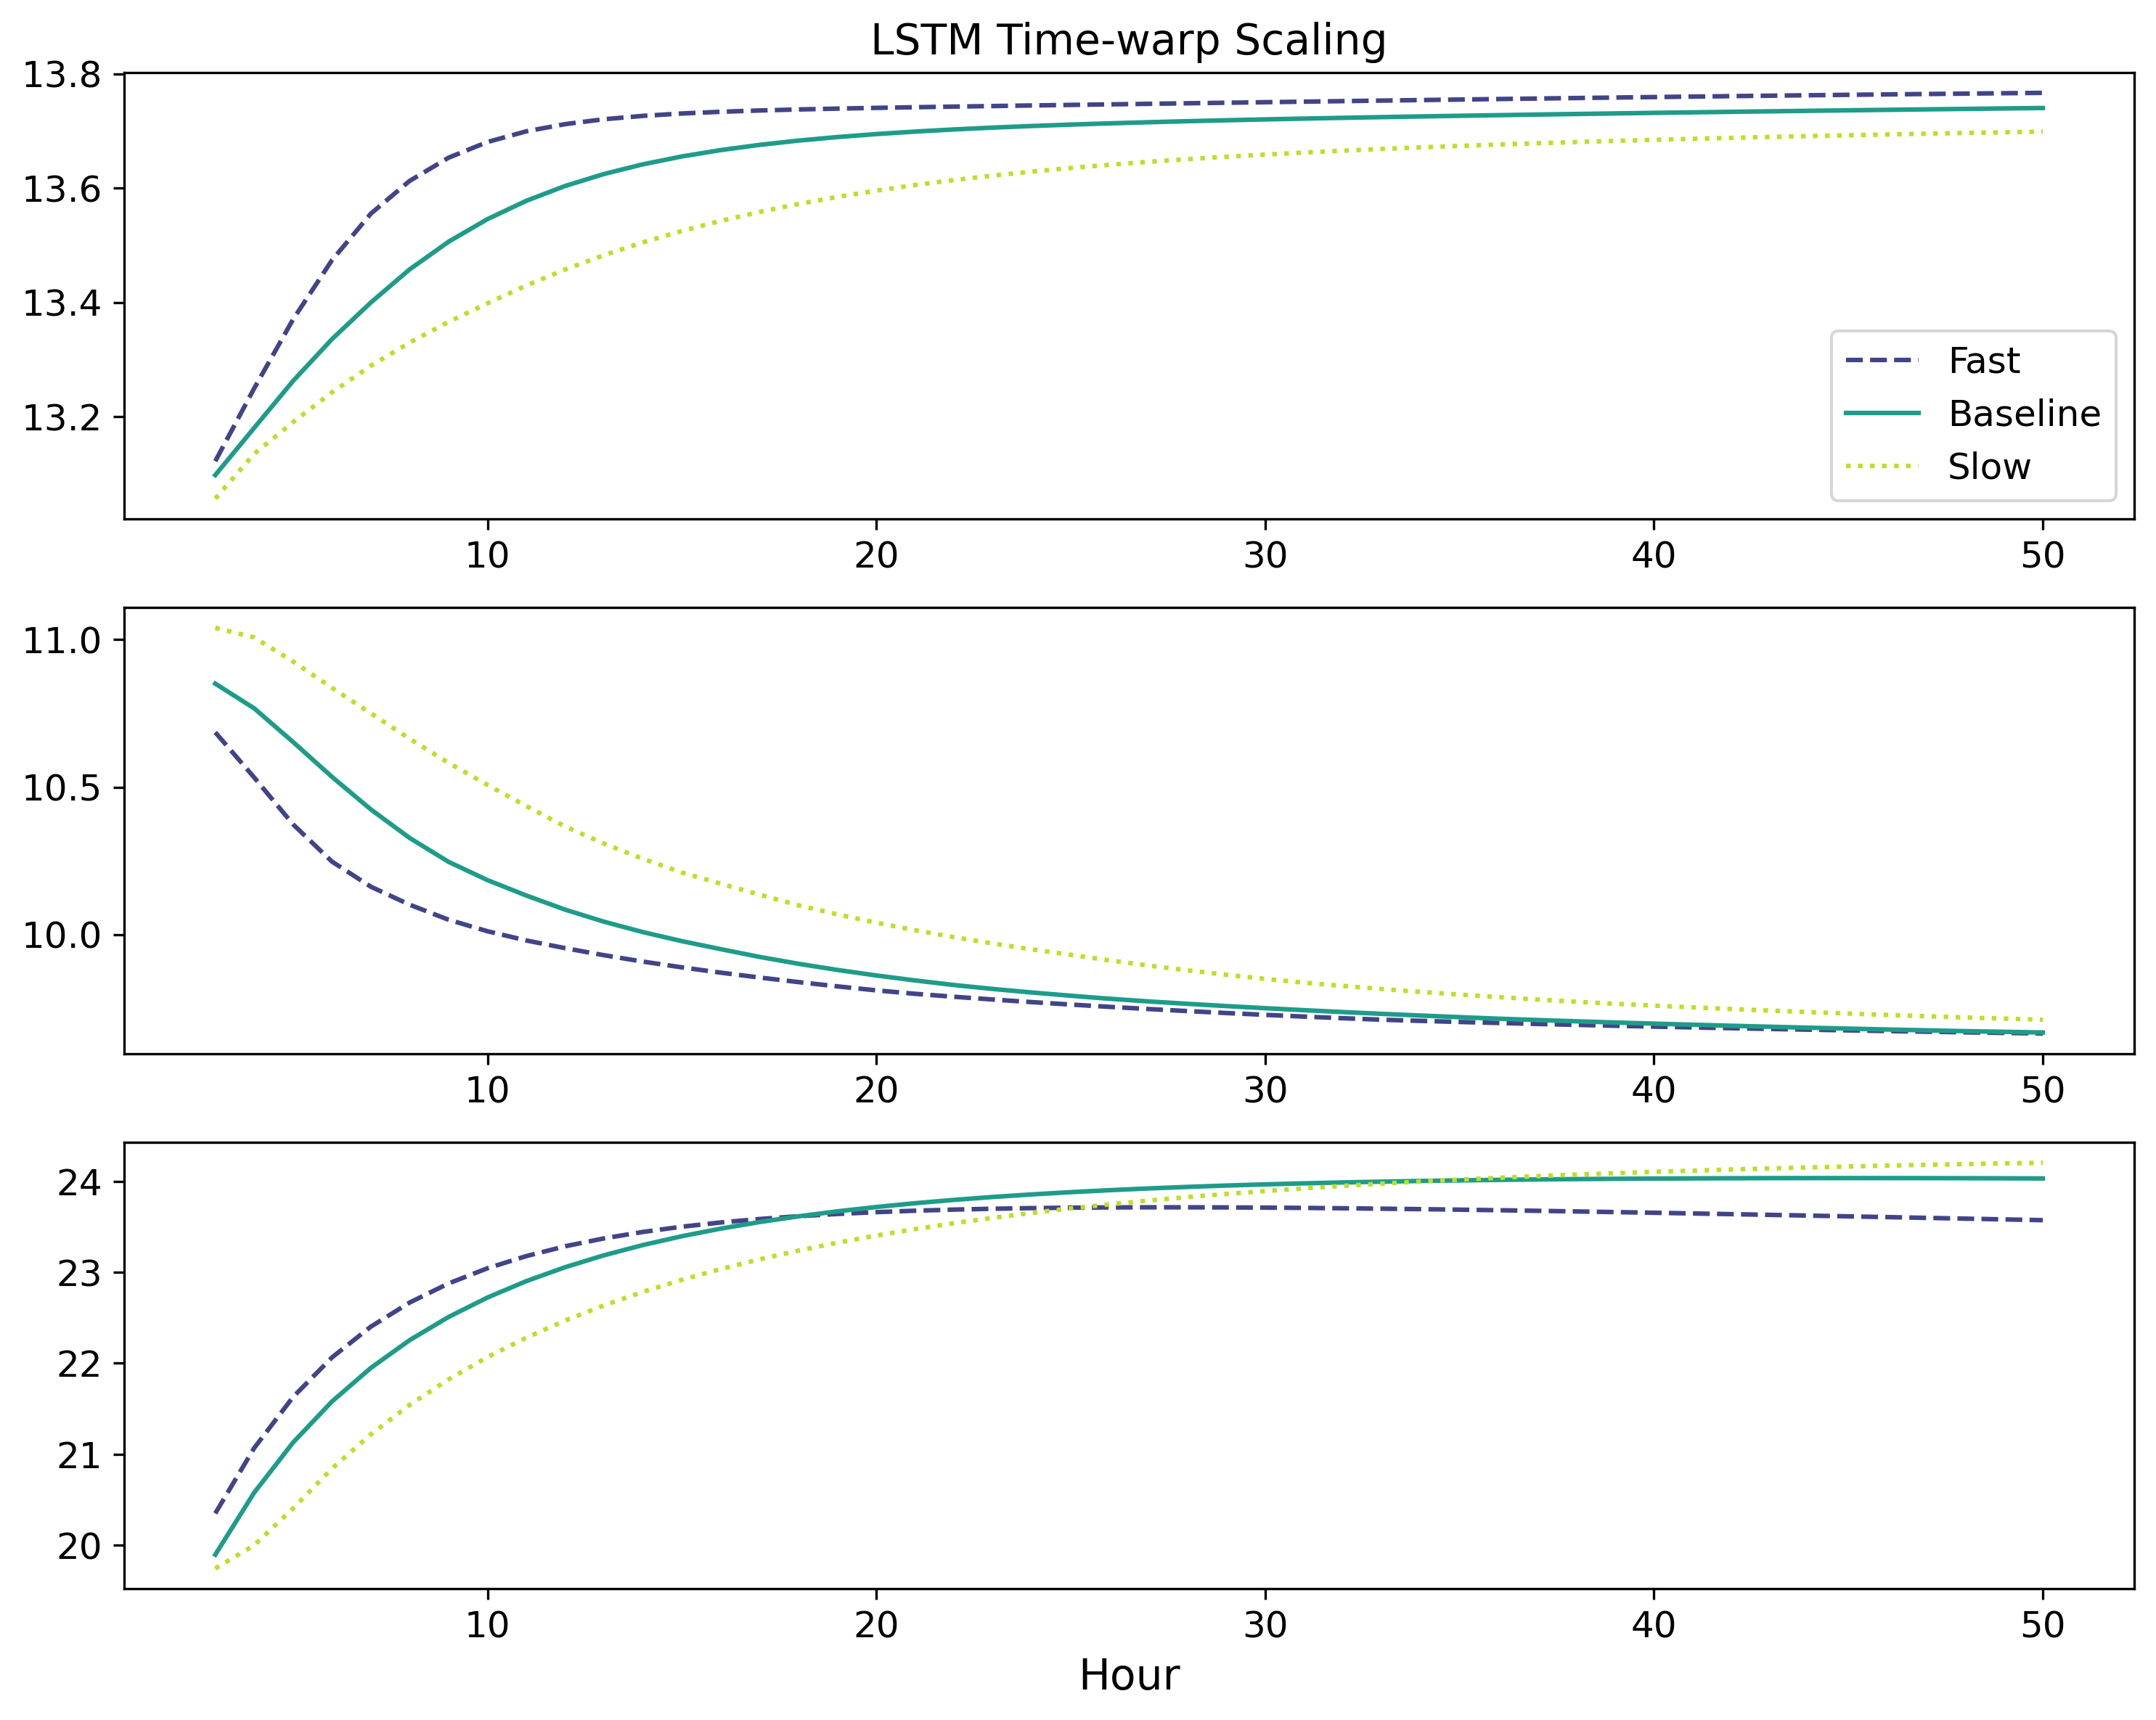

In [19]:
import matplotlib.dates as mdates

# document-safe defaults
FIGSIZE = (10, 8)
DPI = 300
LABEL_SIZE = 14
TICK_SIZE = 12
CBAR_LABEL_SIZE = 13

# Plotting predictions
xgrid = np.arange(nsteps)

fig, ax = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=FIGSIZE,
    dpi=DPI
)


ax[0].set_title("LSTM Time-warp Scaling", fontsize=LABEL_SIZE)

ax[0].plot(xgrid[spinup:], p0_fast[spinup:], c=colors[0], label="Fast", linestyle="dashed")
ax[0].plot(xgrid[spinup:], p0[spinup:],      c=colors[1], label="Baseline")
ax[0].plot(xgrid[spinup:], p0_slow[spinup:], c=colors[2], label="Slow", linestyle="dotted")

ax[1].plot(xgrid[spinup:], p1_fast[spinup:], c=colors[0], label="Fast", linestyle="dashed")
ax[1].plot(xgrid[spinup:], p1[spinup:],      c=colors[1], label="Baseline")
ax[1].plot(xgrid[spinup:], p1_slow[spinup:], c=colors[2], label="Slow", linestyle="dotted")

ax[2].plot(xgrid[spinup:], p2_fast[spinup:], c=colors[0], label="Fast", linestyle="dashed")
ax[2].plot(xgrid[spinup:], p2[spinup:],      c=colors[1], label="Baseline")
ax[2].plot(xgrid[spinup:], p2_slow[spinup:], c=colors[2], label="Slow", linestyle="dotted")

ax[2].set_xlabel("Hour", fontsize=LABEL_SIZE)

for a in ax:
    a.tick_params(axis="both", labelsize=TICK_SIZE)

handles, labels = ax[0].get_legend_handles_labels()

ax[0].legend(
    handles,
    labels,
    loc="lower right",
    fontsize=TICK_SIZE
)

fig.tight_layout()
fig.savefig("outputs/steady.png", dpi=DPI, bbox_inches="tight")